In [1]:
#%matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim 
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 12
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK']='True'


Random Seed:  12


In [2]:
# Number of workers for dataloader
workers = 8
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 192
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 150
# Number of flowers classes
num_classes = 102
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
from torch.utils.data import ConcatDataset, random_split

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
rotated_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
original_dataset = ConcatDataset([trainset, testset, validdataset])

# create HorizontalFlip dataset
rotated_trainset = torchvision.datasets.Flowers102(root='./data', split='train', transform=rotated_transform, download=True)
rotated_testset = torchvision.datasets.Flowers102(root='./data', split='test', transform=rotated_transform, download=True)
rotated_validset = torchvision.datasets.Flowers102(root='./data', split='val', transform=rotated_transform, download=True)
rotated_dataset = ConcatDataset([rotated_trainset, rotated_testset, rotated_validset])

# split dataset with 4:1 ratio
original_size = len(original_dataset)
rotated_size = original_size // 4 
rotated_dataset, _ = random_split(rotated_dataset, [rotated_size, len(rotated_dataset) - rotated_size])

final_dataset = ConcatDataset([original_dataset, rotated_dataset])

dataloader = torch.utils.data.DataLoader(final_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("訓練集樣本數量:", len(final_dataset))

訓練集樣本數量: 10236


In [4]:
rotated_size = original_size // 4
print("有做翻轉數據集樣本數量:", rotated_size)

有做翻轉數據集樣本數量: 2047


In [5]:
final_dataset[0][0].shape

torch.Size([3, 64, 64])

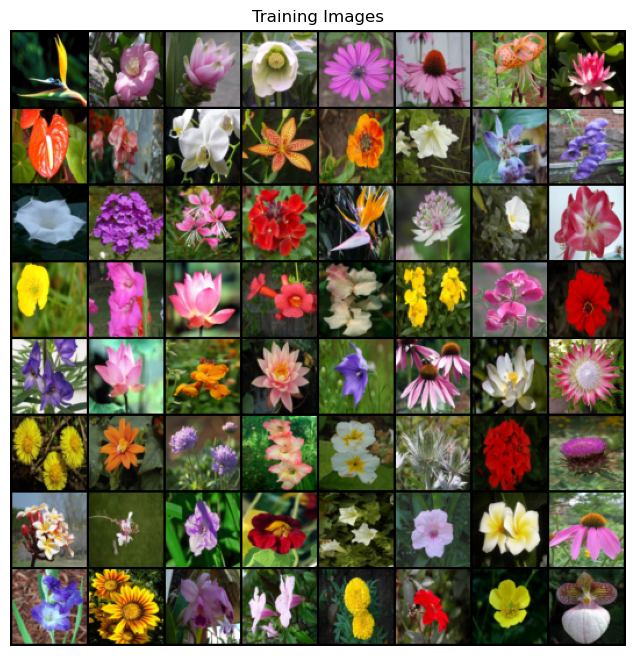

In [6]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Initialize parameters of Generator and Discriminator
This step for initializing the parameters of the generator and discriminator.
And define the structure of the dcGAN.

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # state size. (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),#(1-1)*1+4=4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
            # state size. (ngf*4) x 4 x 4
        )
        self.label = nn.Sequential(
            # state size. (num_classes) x 1 x 1
            nn.ConvTranspose2d(num_classes, ngf * 4, 4, 1, 0, bias=False),#(1-1)*1+4=4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
            # state size. (ngf*4) x 4 x 4
        )
        self.main = nn.Sequential(
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),#(4-1)*2+4=8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),#(8-1)*2+4=16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),#(16-1)*2+4=32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (nc) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),#(32-1)*2+4=64
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 32 x 32
        )
        self.label = nn.Sequential(
            # input is (num_classes) x 64 x 64
            nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 32 x 32
        )
        self.main = nn.Sequential(
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),#(32-4+2*1)/2+1=16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),#(16-4+2*1)/2+1=8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 4, 4, 2, 1, bias=False),#(8-4+2*1)/2+1=4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),#(4-4+2*0)/1+1=1
            # state size. (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [10]:
# Model
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netG.apply(weights_init)
netD.apply(weights_init)
# Print the model
print(netG)
print(netD)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(192, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(102, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1

In [11]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
real_label_num = 1.
fake_label_num = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.AdamW(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.AdamW(netG.parameters(), lr=lr, betas=(beta1, 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=5, gamma=0.5)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=5, gamma=0.5)

# Label one-hot for G
label_1hots = torch.zeros(num_classes,num_classes)
for i in range(num_classes):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(num_classes,num_classes,1,1).to(device)
# Label one-hot for D
label_fills = torch.zeros(num_classes, num_classes, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(num_classes):
    label_fills[i][i] = ones  
label_fills = label_fills.to(device)
# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(num_classes, nz, 1, 1, device=device)
# print(fixed_noise.shape)
fixed_label = label_1hots[torch.arange(num_classes)]
# print(fixed_label.shape)

In [12]:
import torchvision.models as models
import torch.nn as nn

# use vgg16 to calculate perceptual loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # get the 16th layer of vgg16
        vgg = models.vgg16(pretrained=True).features[:16].eval() 
        self.vgg = vgg.to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False  

    def forward(self, fake, real):
        # calculate the features of fake and real
        fake_features = self.vgg(fake)
        real_features = self.vgg(real)
        # calculate the perceptual loss
        loss = nn.functional.mse_loss(fake_features, real_features)
        return loss
perceptual_loss = PerceptualLoss()

/home/pui/miniforge3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pui/miniforge3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Step

In [13]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10
iters = 0
# masked_real_cpu = add_random_mask(real_cpu.clone())
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_image = data[0].to(device)
        # print('real_image:',real_image.size())#real_image: ([batch_size, channel, img_size, img_size])
        b_size = real_image.size(0)

        real_label = torch.full((b_size,), 0.9).to(device)# Label Smoothing 1 -> 0.9
        # print('real_label:',real_label.size())#real_label: ([batch_size])
        fake_label = torch.full((b_size,), fake_label_num).to(device)
        # print('fake_label:',fake_label.size())#fake_label: ([batch_size])
        
        G_label = label_1hots[data[1]]
        # print('G_label:',G_label.size())#G_label: ([batch_size, class_num, 1, 1])
        D_label = label_fills[data[1]]
        # print('D_label:',D_label.size())#D_label: ([batch_size, class_num, img_size, img_size])

        # Forward pass real batch through D
        output = netD(real_image, D_label).view(-1)
        # print('output:',output.size())#output: ([batch_size])
        # Calculate loss on all-real batch
        errD_real = criterion(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).to(device)
        # Generate fake image batch with G
        fake = netG(noise, G_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), D_label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        fake = netG(noise, G_label)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, D_label).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label)
        # calculate perceptual loss
        perceptual_err = perceptual_loss(fake, real_image)
        # total error = GAN loss + weight * perceptual loss
        total_errG = errG + 0.1 * perceptual_err
        total_errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_label).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/150][0/80]	Loss_D: 1.6890	Loss_G: 3.3136	D(x): 0.6258	D(G(z)): 0.6232 / 0.0382
[0/150][50/80]	Loss_D: 0.6400	Loss_G: 4.5473	D(x): 0.8246	D(G(z)): 0.1299 / 0.0074
[1/150][0/80]	Loss_D: 0.5654	Loss_G: 3.7376	D(x): 0.7630	D(G(z)): 0.1215 / 0.0227
[1/150][50/80]	Loss_D: 0.5950	Loss_G: 2.9557	D(x): 0.7630	D(G(z)): 0.1381 / 0.0444
[2/150][0/80]	Loss_D: 0.7701	Loss_G: 3.2243	D(x): 0.7318	D(G(z)): 0.2233 / 0.0322
[2/150][50/80]	Loss_D: 1.2448	Loss_G: 1.2905	D(x): 0.4162	D(G(z)): 0.1826 / 0.2734
[3/150][0/80]	Loss_D: 0.7648	Loss_G: 3.1056	D(x): 0.6814	D(G(z)): 0.1803 / 0.0405
[3/150][50/80]	Loss_D: 1.1719	Loss_G: 2.6897	D(x): 0.7461	D(G(z)): 0.4843 / 0.0637
[4/150][0/80]	Loss_D: 1.0207	Loss_G: 2.6459	D(x): 0.6846	D(G(z)): 0.3881 / 0.0636
[4/150][50/80]	Loss_D: 0.6794	Loss_G: 2.0557	D(x): 0.7353	D(G(z)): 0.2013 / 0.1186
[5/150][0/80]	Loss_D: 0.9950	Loss_G: 2.6543	D(x): 0.6991	D(G(z)): 0.3795 / 0.0712
[5/150][50/80]	Loss_D: 0.8757	Loss_G: 1.8449	D(x): 0.6276	D(G(z)): 

In [14]:
# Save the final Model
torch.save(netG.state_dict(), './model_weight/Generator weights.pth')
torch.save(netD.state_dict(), './model_weight/Discriminator weights.pth')

## Create fake dataset for calculating FID scores
FID scores use to evaluate the similarity between two datasets.

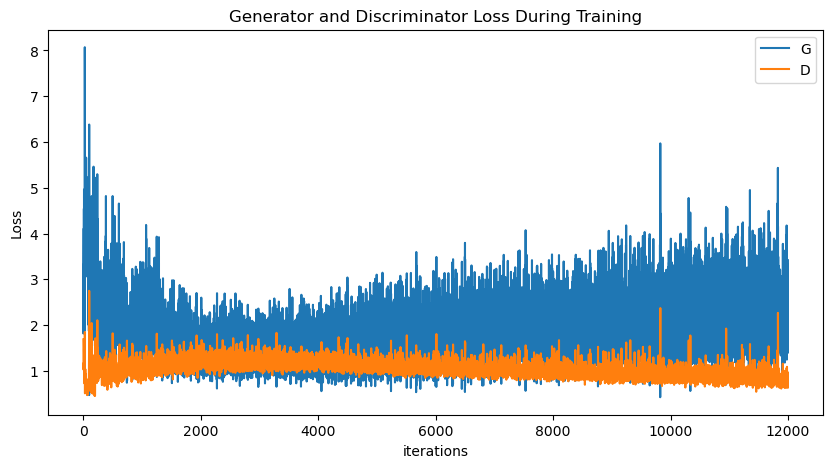

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# netG = Generator(ngpu).to(device)
# netG.load_state_dict(torch.load("./model_weight/Generator weights.pth"))

In [17]:
import torchvision.transforms as T

num_images = 8189
# generate 8189 random class 1-hot labels
label_1hots = torch.eye(num_classes).view(num_classes, num_classes, 1, 1).to(device)
# random generate 8189 labels
random_labels = torch.randint(0, num_classes, (num_images,), device=device)
# according to the randomly generated label index, take out the corresponding one-hot encoding
expanded_label = label_1hots[random_labels]
noise = torch.randn(num_images, nz, 1, 1, device=device)

netG.eval() 
# use small batch to generate interpolated images
batch_size = 32
for i in range(0, num_images, batch_size):
    batch_noise = noise[i:i + batch_size]
    batch_label = expanded_label[i:i + batch_size]
    
    with torch.no_grad():
        fake = netG(batch_noise, batch_label).detach().cpu()

    for j in range(fake.size(0)):
        img = fake[j] 
        # normalize the pixel value from [-1, 1] to [0, 1]
        img = (img + 1) / 2 
        transform = T.ToPILImage()
        new_img = transform(img)
        new_img.save(f'./GENIMG/fake' + str(i + j) + '.jpg')

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from pytorch_fid import fid_score
from PIL import Image
import os

## The path of original dataset resized into 64x64 pixels.
resized_folder_path = './resized/'
## The path of generated dataset.
generated_images_folder = './GENIMG/'
## Use Model Inception V3 to calculate FID score. (Inception V3 is a pre-trained model)
inception_model = torchvision.models.inception_v3(pretrained=True)
fid_value = fid_score.calculate_fid_given_paths([resized_folder_path, generated_images_folder], batch_size =batch_size, device=device , dims=2048, num_workers=4)
print('FID value:', fid_value)

/home/pui/miniforge3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 256/256 [00:10<00:00, 24.71it/s]


FID value: 52.062132207085426


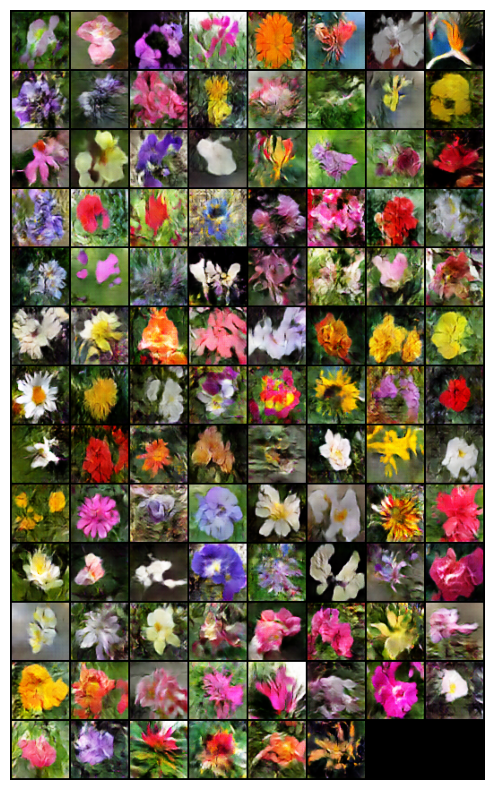

In [19]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(10, 10))
plt.axis("off")

# initialization
im = plt.imshow(np.transpose(img_list[0], (1, 2, 0)))
def update(frame):
    im.set_array(np.transpose(img_list[frame], (1, 2, 0))) 
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(img_list), interval=200, blit=True)
ani.save("animation.gif", writer="pillow", fps=1)

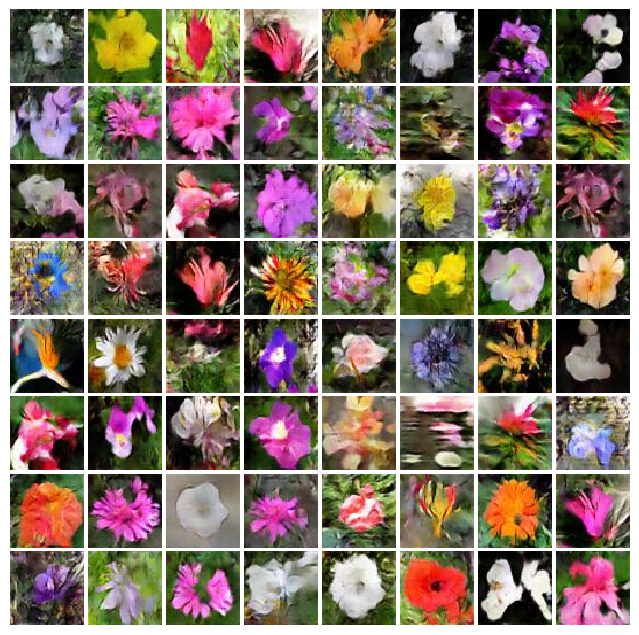

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from PIL import Image
# set the folder path
generated_images_folder = './GENIMG/'
# load all images
image_paths = glob.glob(generated_images_folder + '*.jpg')
# randomly select 64 images
random_images = random.sample(image_paths, min(64, len(image_paths)))
# show images
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for ax, img_path in zip(axs.flatten(), random_images):
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img, interpolation='nearest')
    ax.axis("off")
plt.show()